## ***Project Title:***
#### User Journey Funnel Analysis

This project analyzes the user journey of customers from a Brazilian e-commerce platform, using the public Olist dataset. The focus is on understanding the drop-off points in the customer funnel — from order placement to delivery and review. The goal is to identify potential UX bottlenecks and business insights that can improve conversion rates and customer satisfaction.

### **Project Objective**
Analyze and quantify each stage of the customer journey.

Identify drop-off stages in the funnel.

Explore average delivery time and review behavior.

Prepare the data for dashboard in Power BI.

### **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
sns.set_style("whitegrid")

### **Loading Data**

In [ ]:
data_path = 'C:/Users/hites/Downloads/User-Journey-Funnel-Analysis-and-Dashboard-main/User-Journey-Funnel-Analysis-and-Dashboard-main/data'

customers = pd.read_csv(os.path.join(data_path, 'olist_customers_dataset.csv'))
orders = pd.read_csv(os.path.join(data_path, 'olist_orders_dataset.csv'))
order_items = pd.read_csv(os.path.join(data_path, 'olist_order_items_dataset.csv'))
products = pd.read_csv(os.path.join(data_path, 'olist_products_dataset.csv'))
payments = pd.read_csv(os.path.join(data_path, 'olist_order_payments_dataset.csv'))
reviews = pd.read_csv(os.path.join(data_path, 'olist_order_reviews_dataset.csv'))

### **Data Overview and Exploration**

In [ ]:
# Customers overview
print("Customers shape:", customers.shape)
print(customers.head())
print(customers['customer_state'].value_counts())

# Orders overview
print("\nOrders shape:", orders.shape)
print(orders.head())
print("Order status distribution:\n", orders['order_status'].value_counts(normalize=True))

# Payments overview
print("\nPayments shape:", payments.shape)
print(payments.head())
print("Payment types distribution:\n", payments['payment_type'].value_counts(normalize=True))

# Reviews overview
print("\nReviews shape:", reviews.shape)
print(reviews.head())
print("Review scores distribution:\n", reviews['review_score'].value_counts(normalize=True))

Customers shape: (99441, 5)
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  
customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO

#### **Data Cleaning & Conversion**

In [ ]:
# Convert relevant columns to datetime
date_cols_orders = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                    'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_cols_orders:
    orders[col] = pd.to_datetime(orders[col])

reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'])

### **Merge Data for Full Journey Table**

In [ ]:
order_payment = pd.merge(orders, payments, on='order_id', how='left')
order_review = pd.merge(order_payment, reviews, on='order_id', how='left')
order_full = pd.merge(order_review, customers[['customer_id', 'customer_state']], on='customer_id', how='left')

### **Define Funnel Stages (Boolean flags for stages)**

In [ ]:
order_full['stage_order_placed'] = ~order_full['order_approved_at'].isna()
order_full['stage_payment_made'] = order_full['stage_order_placed'] & ~order_full['payment_value'].isna()
order_full['stage_delivered'] = order_full['stage_payment_made'] & ~order_full['order_delivered_customer_date'].isna()
order_full['stage_review_given'] = order_full['stage_delivered'] & ~order_full['review_score'].isna()

### **Funnel Data Summary**

In [ ]:
stages = ['stage_order_placed', 'stage_payment_made', 'stage_delivered', 'stage_review_given']
stage_names = ['Order Placed', 'Payment Made', 'Order Delivered', 'Review Given']

funnel_counts = [order_full[stage].sum() for stage in stages]
funnel_df = pd.DataFrame({'Stage': stage_names, 'Users': funnel_counts})
funnel_df['Drop Off %'] = funnel_df['Users'].pct_change().fillna(0).abs() * 100
print(funnel_df)

             Stage   Users  Drop Off %
0     Order Placed  104302    0.000000
1     Payment Made  104301    0.000959
2  Order Delivered  101309    2.868621
3     Review Given  100633    0.667265


### Funnel Analysis Insights
- The funnel shows how users progress from placing an order to reviewing it.
- Significant drop-offs can indicate friction points in the shopping experience:
  - If many users place orders but don’t complete payment, payment UX may need attention.
  - A drop from payment to delivery may highlight shipping/logistics issues.
  - A low number of reviews may indicate poor post-purchase engagement.

We'll visualize this below for a clearer picture.

### **Visualize the Funnel (Bar + stepwise drop-off)**

C:\Users\hites\AppData\Local\Temp\ipykernel_6592\3518782865.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x='Users', y='Stage', data=funnel_df, palette='Blues_d')


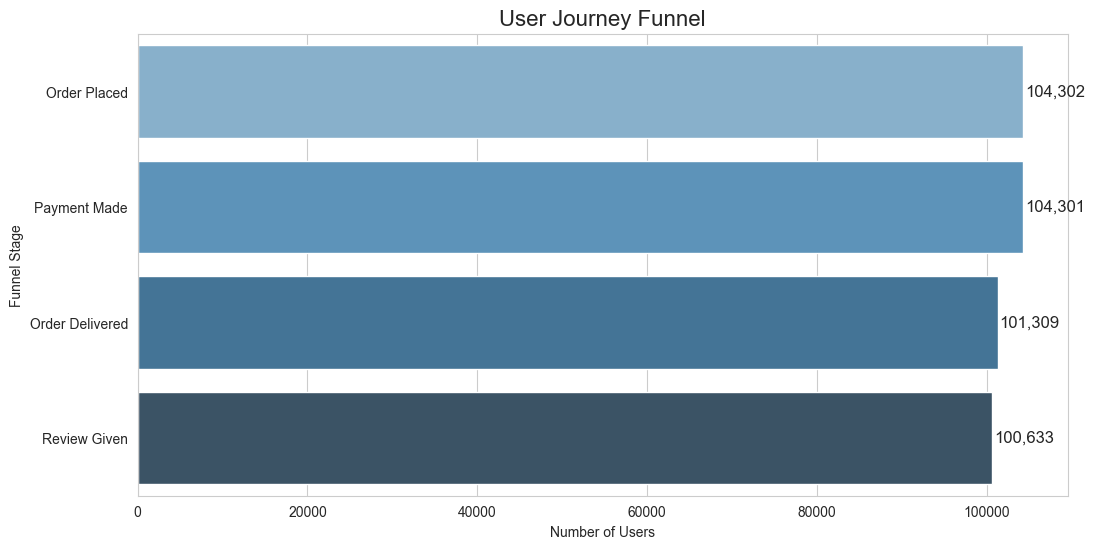

In [ ]:
plt.figure(figsize=(12, 6))
bar = sns.barplot(x='Users', y='Stage', data=funnel_df, palette='Blues_d')
for i, row in funnel_df.iterrows():
    bar.text(row['Users'] + 200, i, f"{row['Users']:,}", va='center', fontsize=12)
plt.title("User Journey Funnel", fontsize=16)
plt.xlabel("Number of Users")
plt.ylabel("Funnel Stage")
plt.show()

### **Analyze Time Delays (Delivery and Review)**

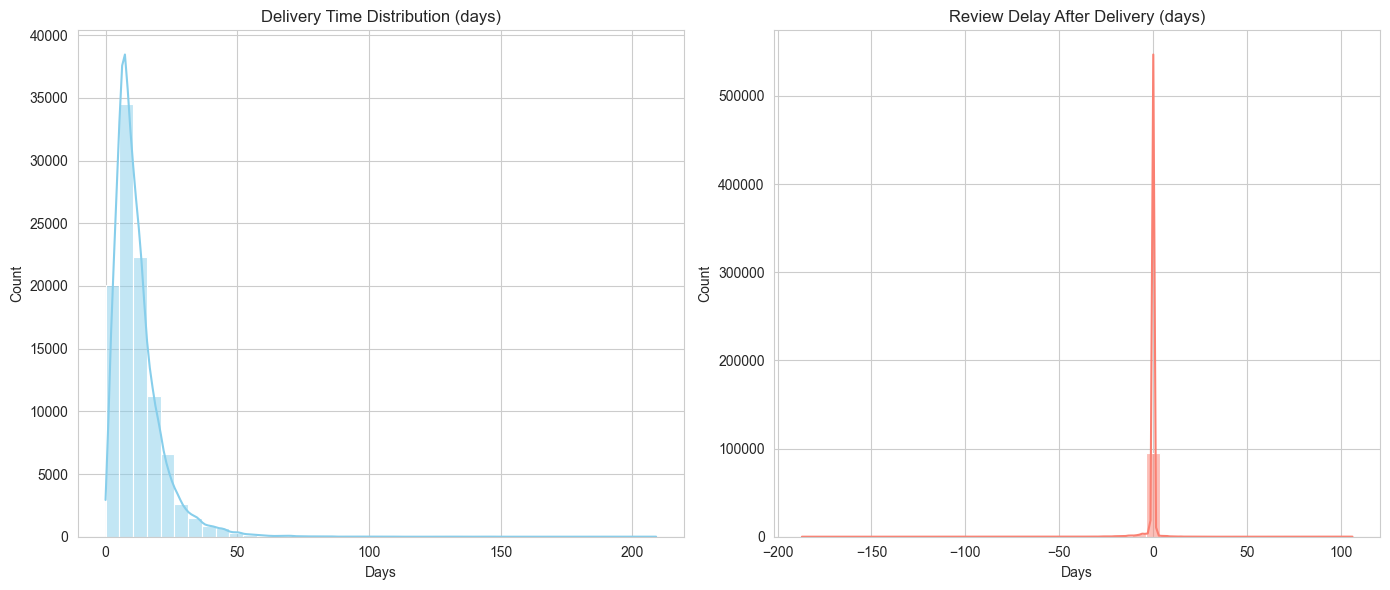

In [ ]:
order_full['delivery_time_days'] = (order_full['order_delivered_customer_date'] - order_full['order_purchase_timestamp']).dt.days
order_full['review_delay_days'] = (order_full['review_creation_date'] - order_full['order_delivered_customer_date']).dt.days

# Histograms for Delivery & Review Delays
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(order_full['delivery_time_days'].dropna(), bins=40, kde=True, color='skyblue')
plt.title('Delivery Time Distribution (days)')
plt.xlabel('Days')

plt.subplot(1, 2, 2)
sns.histplot(order_full['review_delay_days'].dropna(), bins=40, kde=True, color='salmon')
plt.title('Review Delay After Delivery (days)')
plt.xlabel('Days')
plt.tight_layout()
plt.show()

### **Temporal Trends of Orders and Payments**

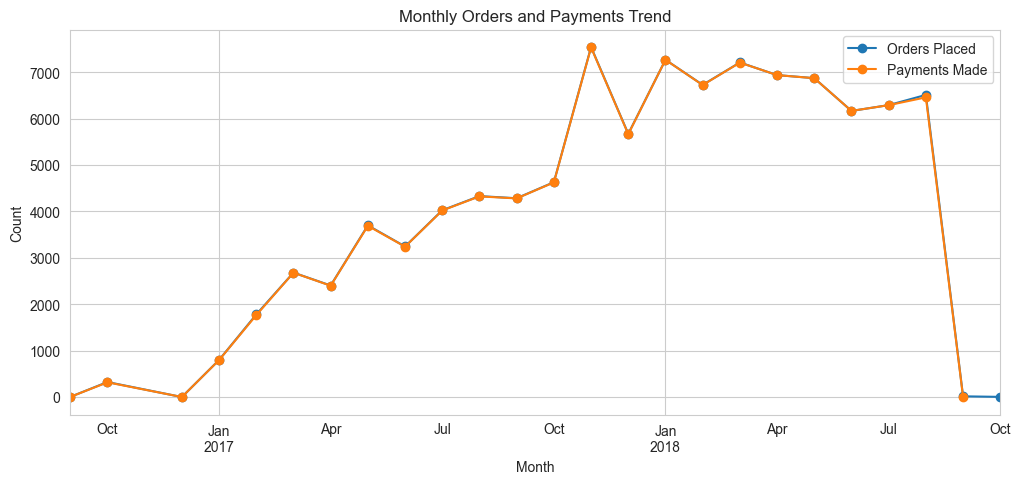

In [ ]:
order_full['purchase_month'] = order_full['order_purchase_timestamp'].dt.to_period('M')
monthly_orders = order_full.groupby('purchase_month')['order_id'].nunique()
monthly_payments = order_full[order_full['stage_payment_made']].groupby('purchase_month')['order_id'].nunique()

plt.figure(figsize=(12, 5))
monthly_orders.plot(label='Orders Placed', marker='o')
monthly_payments.plot(label='Payments Made', marker='o')
plt.legend()
plt.title('Monthly Orders and Payments Trend')
plt.xlabel('Month')
plt.ylabel('Count')
plt.grid(True)
plt.show()

### **Payment Types Analysis (Drop-off by payment type)**

              stage_delivered  stage_order_placed  stage_payment_made  \
payment_type                                                            
boleto                  19294               19880               19880   
credit_card             74975               77141               77141   
debit_card               1492                1536                1536   
not_defined                 0                   0                   0   
voucher                  5548                5744                5744   

              drop_off_payment  drop_off_delivery  
payment_type                                       
boleto                     0.0           0.029477  
credit_card                0.0           0.028078  
debit_card                 0.0           0.028646  
not_defined                NaN                NaN  
voucher                    0.0           0.034123  


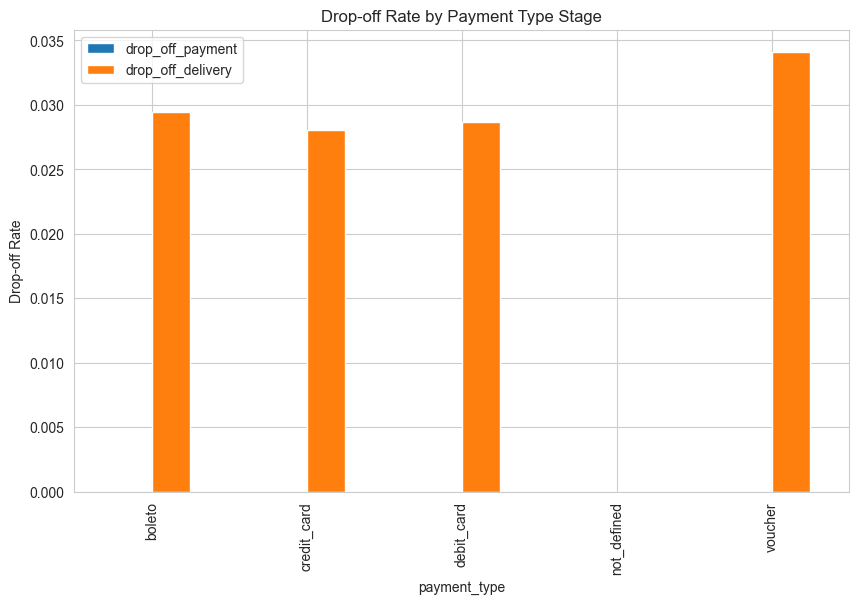

In [ ]:
payment_stage_pivot = order_full.pivot_table(index='payment_type', 
                                            values=['stage_order_placed', 'stage_payment_made', 'stage_delivered'], 
                                            aggfunc='sum')

payment_stage_pivot['drop_off_payment'] = 1 - payment_stage_pivot['stage_payment_made'] / payment_stage_pivot['stage_order_placed']
payment_stage_pivot['drop_off_delivery'] = 1 - payment_stage_pivot['stage_delivered'] / payment_stage_pivot['stage_payment_made']
print(payment_stage_pivot)

payment_stage_pivot[['drop_off_payment', 'drop_off_delivery']].plot(kind='bar', figsize=(10, 6))
plt.title('Drop-off Rate by Payment Type Stage')
plt.ylabel('Drop-off Rate')
plt.show()

### **Correlation Between Delivery Time and Review Score**

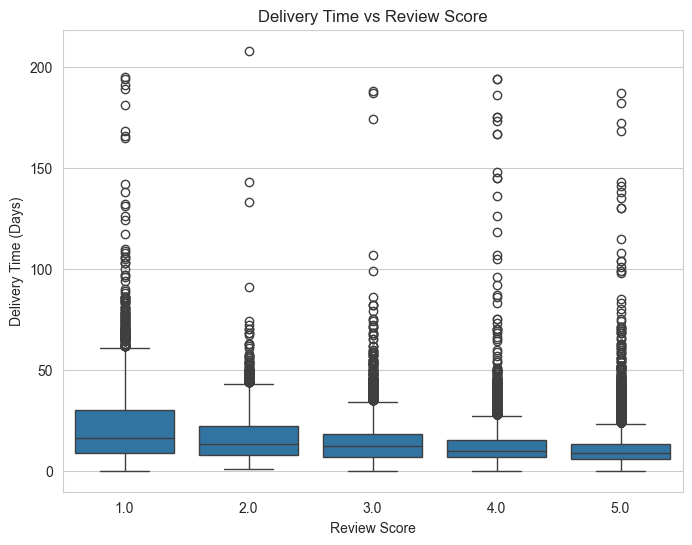

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='review_score', y='delivery_time_days', data=order_full)
plt.title('Delivery Time vs Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Time (Days)')
plt.show()

### **Customer State-Level Funnel Analysis**

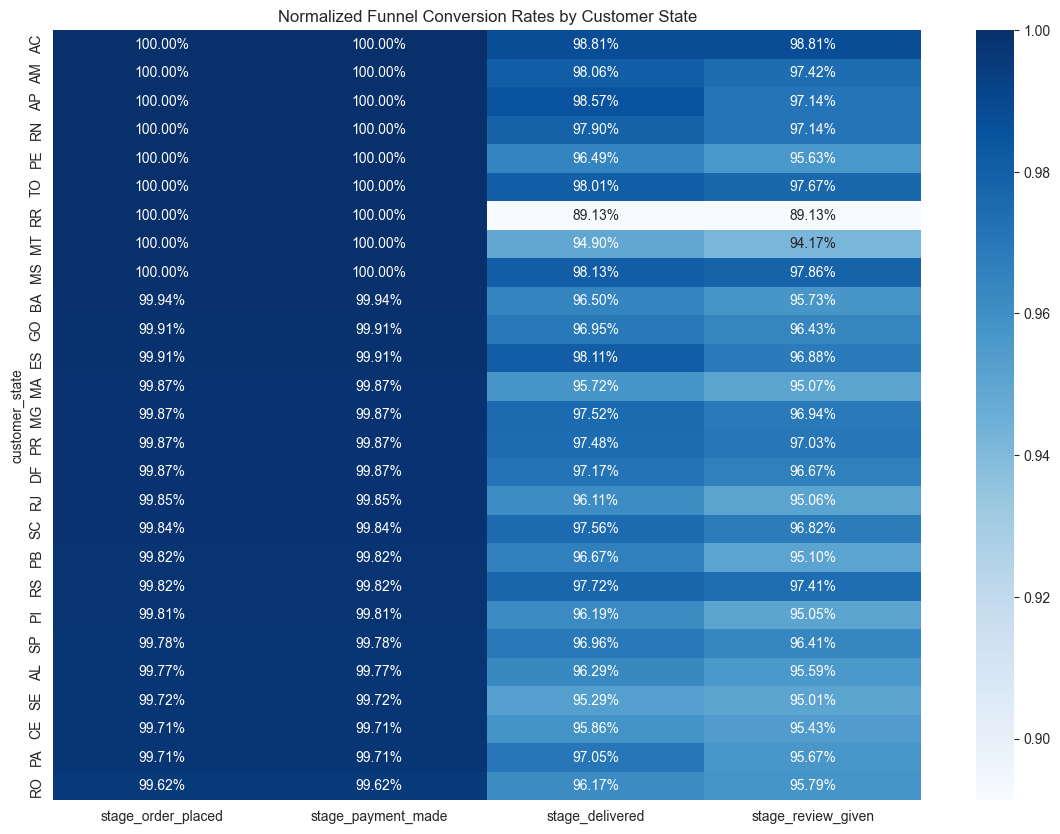

In [ ]:
state_funnel = order_full.groupby('customer_state')[stages].sum()
state_funnel['order_placed_total'] = order_full.groupby('customer_state')['order_id'].count()
state_funnel_norm = state_funnel.div(state_funnel['order_placed_total'], axis=0).sort_values(by='stage_order_placed', ascending=False)

plt.figure(figsize=(14, 10))
sns.heatmap(state_funnel_norm[stages], annot=True, fmt=".2%", cmap='Blues')
plt.title('Normalized Funnel Conversion Rates by Customer State')
plt.show()

### **Export cleaned data for dashboard (including stages and timings)**

In [ ]:
export_cols = [
    'order_id', 'customer_id', 'customer_state', 'order_purchase_timestamp',
    'order_approved_at', 'order_delivered_customer_date', 'payment_value',
    'review_score', 'stage_order_placed', 'stage_payment_made', 'stage_delivered', 'stage_review_given',
    'delivery_time_days', 'review_delay_days'
]
order_full[export_cols].to_csv('order_user_journey_enhanced.csv', index=False)

## Final Summary
- Enhanced exploratory analysis provided detailed distributions and insights about customers, orders, payments, and reviews.
- Clear identification of funnel drop-off points by user count and percentage.
- Temporal trend analysis uncovered seasonal order/payment patterns.
- Payment type analysis revealed differential drop-offs by payment methods.
- Delivery times and review behavior show relationship patterns.
- Heatmaps illustrate funnel conversion variance by customer state.
- Data prepared and exported for Power BI dashboard integration.